In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

np.set_printoptions(precision=2, suppress=True)

Segmentation masks:

0: background

1: tool

2: ILM

3: RPE


In [2]:
masks_path = '/home/demir/Desktop/jhu_project/oct-depth-control/data/may21-1/masks_machine'
masks = []
for mask_img in os.listdir(masks_path):
    mask = cv2.imread(os.path.join(masks_path, mask_img), cv2.IMREAD_GRAYSCALE)
    masks.append(mask)

[0 1 2 3]


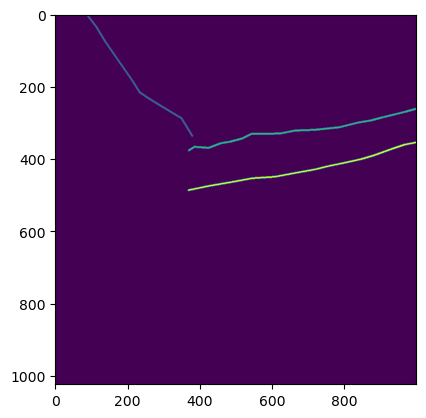

In [28]:
test_img = cv2.imread('/home/demir/Desktop/jhu_project/oct-depth-control/data/may21-1/masks_machine/volume_0_slice_2.png', cv2.IMREAD_GRAYSCALE)
print(np.unique(test_img))
filtered_img = (test_img == 1).astype(int)
plt.imshow(test_img)

In [43]:
def find_layers_coords(image, a_scan):
    try:
        ilm_row = np.where(image[:, a_scan] == 2)[0][0]
        rpe_row = np.where(image[:, a_scan] == 3)[0][0]
        return a_scan, ilm_row, rpe_row
    except IndexError:
        print('ILM or RPE not visible under needle tip')
        left = find_layers_coords(image, a_scan-1)
        right = find_layers_coords(image, a_scan+1)
        closest_scan = left if abs(left[0] - a_scan) < abs(right[0] - a_scan) else right
        return closest_scan
    

def calc_normalized_pos_between_layers(ilm_row, rpe_row, needle_tip_row):
    if needle_tip_row < ilm_row:
        print('needle tip is above ILM')
        return 0
    elif needle_tip_row > rpe_row:
        print('needle tip is below RPE')
        return 1
    return (needle_tip_row - ilm_row) / (rpe_row - ilm_row)

def volume_find_needle_tip_largest_component(segmented_b_scans, needle_label=1, min_area=150):
    largest_component_area = 0
    needle_tip_largest_component = None
    slice_idx_largest_component = -1
    for slice_idx, b_scan in enumerate(segmented_b_scans):
        needle_mask = (b_scan == needle_label).astype(np.uint8) * 255

        # Morphological opening to remove small noise
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        cleaned_mask = cv2.morphologyEx(needle_mask, cv2.MORPH_OPEN, kernel)

        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(cleaned_mask, connectivity=8)

        # remove components with bounding box area less than min_area
        valid_components = [(i, stats[i, cv2.CC_STAT_AREA]) for i in range(1, num_labels) if stats[i, cv2.CC_STAT_AREA] >= min_area]

        if valid_components:
            # tuple with component index and area 
            largest_component = max(valid_components, key=lambda x: x[1])

            if largest_component[1] > largest_component_area:
                component_label, largest_component_area = largest_component
                component_mask = (labels == component_label)
                y_coords, x_coords = np.where(component_mask)
                lowest_pixel = np.argmax(y_coords)
                needle_tip = (x_coords[lowest_pixel], y_coords[lowest_pixel])
                needle_tip_largest_component = needle_tip
                slice_idx_largest_component = slice_idx

    return (slice_idx_largest_component, needle_tip_largest_component)


In [ ]:
# example usage
# target depth should be selected by the user in the beginning
target_depth = 0.5
# Segmented b-scans should come from the network as a list
segmented_b_scans = [] # N b-scans, N: number of b-scans in volume, each b-scan is a 2D numpy array
slice_idx, needle_tip = volume_find_needle_tip_largest_component(segmented_b_scans) 
a_scan, ilm_row, rpe_row = find_layers_coords(segmented_b_scans[slice_idx], needle_tip[0])
normalized_pos = calc_normalized_pos_between_layers(ilm_row, rpe_row, needle_tip[1])
if normalized_pos >= target_depth:
    print('needle tip is at or below target depth')